In [3]:
import sys
import stellargraph as sg

In [4]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
batch_size = 200
epochs = 20
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [6]:
dataset = datasets.MovieLens()
display(HTML(dataset.description))
G, edges_with_ratings = dataset.load()

In [12]:
len(G.nodes()),len(G.edges()) 

(2625, 100000)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2625, Edges: 100000

 Node types:
  movie: [1682]
    Features: float32 vector, length 19
    Edge types: movie-rating->user
  user: [943]
    Features: float32 vector, length 24
    Edge types: user-rating->movie

 Edge types:
    movie-rating->user: [100000]
        Weights: all 1 (default)
        Features: none


In [14]:
edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["user_id", "movie_id"]].itertuples(index=False))
edgelist_test = list(edges_test[["user_id", "movie_id"]].itertuples(index=False))

labels_train = edges_train["rating"]
labels_test = edges_test["rating"]

In [17]:
num_samples = [8, 4]

In [18]:
generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "movie"]
)

train_gen = generator.generator(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

In [19]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('movie', [3]),
 ('movie', [4]),
 ('user', [5]),
 ('user', []),
 ('movie', [])]

In [20]:
generator.schema.schema

{'user': [EdgeType(n1='user', rel='rating', n2='movie')],
 'movie': [EdgeType(n1='movie', rel='rating', n2='user')]}

In [21]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes = hinsage_layer_sizes, generator = generator, bias = True, dropout = 0.0
)

In [24]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

In [53]:
x_inp

[<KerasTensor: shape=(None, 1, 24) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1, 19) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 8, 19) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 8, 24) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 32, 24) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 32, 19) dtype=float32 (created by layer 'input_6')>]

In [26]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [27]:
import tensorflow.keras.backend as K

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs = x_inp, outputs = score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 19)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 24)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 19)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 24)]      0                                            
______________________________________________________________________________________________

In [29]:
# Specify the number of workers to use for model training
num_workers = 4

In [30]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

150/150 [==============================] - 12s 68ms/step - loss: 11.6525 - root_mean_square_error: 3.4127 - mean_absolute_error: 3.2189 12s - loss: 11.5372 - root_mean_square_er - ETA: 7s - loss: 11.5712 - root_mean_square_error: 3.4008 - mean_absol - ETA: 5s - loss: 11.6045 - root_mean_s
Untrained model's Test Evaluation:
	loss: 11.7293
	root_mean_square_error: 3.4241
	mean_absolute_error: 3.2295


In [31]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/20
350/350 [==============================] - 39s 105ms/step - loss: 1.3172 - root_mean_square_error: 1.1287 - mean_absolute_error: 0.9345 - val_loss: 1.1482 - val_root_mean_square_error: 1.0705 - val_mean_absolute_error: 0.8628 - loss: 2.9243 - root_mean_square_error: 1.6054 - mean_absolu - ETA: 25s - loss: 2.2099 - root_mean_square_error: 1.4008 - mean_absolute_error: 1.186 - ETA: 25s - loss: 2.1898 - root_mean - ETA: 18s - loss: 1.6195  - ETA: 12s - loss: 1.4430 - root_mean_squar - ETA: 1s - loss: 1.3247 - root_mean_square_error: 1.1313 - mean_absolute_err
Epoch 2/20
350/350 [==============================] - 39s 109ms/step - loss: 1.1449 - root_mean_square_error: 1.0686 - mean_absolute_error: 0.8681 - val_loss: 1.1272 - val_root_mean_square_error: 1.0606 - val_mean_absolute_error: 0.8721
Epoch 3/20
350/350 [==============================] - 38s 108ms/step - loss: 1.1357 - root_mean_square_error: 1.0644 - mean_absolute_error: 0.8621 - val_loss: 1.1159 - val_root_mean_square_

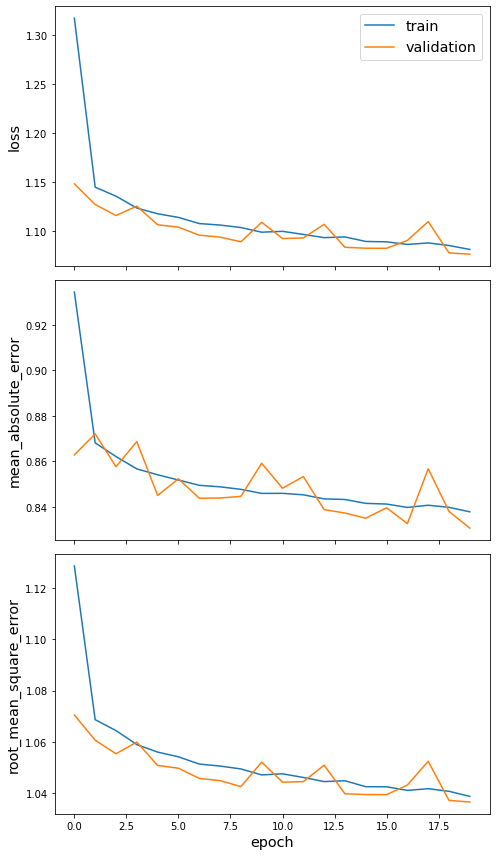

In [33]:
sg.utils.plot_history(history)

In [34]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

150/150 [==============================] - 11s 72ms/step - loss: 1.0767 - root_mean_square_error: 1.0365 - mean_absolute_error: 0.83154s - loss: 1.0700 - root_mean_square_error: 1. - ETA: 3s - loss: 1.0698 - root_mean_square_error: 1.0332 - mean_absolute - ETA: 2s - loss: 1.0709 - root_mean_square_e
Test Evaluation:
	loss: 1.0767
	root_mean_square_error: 1.0365
	mean_absolute_error: 0.8315


In [35]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.1221461456611712
	mean_absolute_error =  0.9433370764732361

Model Test set metrics:
	root_mean_square_error =  1.0363052497365077
	mean_absolute_error =  0.830336329015096


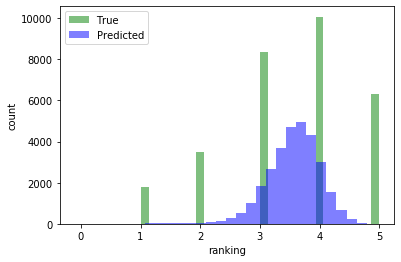

In [36]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [6]:
import numpy as np
from tensorflow.keras.layers import *

In [7]:
Multiply()([np.arange(5).reshape(5, 1),
                            np.arange(5, 10).reshape(5, 1)])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 0],
       [ 6],
       [14],
       [24],
       [36]])>

In [8]:
np.arange(5).reshape(5, 1)

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [9]:
np.arange(5, 10).reshape(5, 1)

array([[5],
       [6],
       [7],
       [8],
       [9]])